In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pdb
import matplotlib.ticker as ticker
from metpy.units import units as u
import metpy.constants as const
from matplotlib.gridspec import GridSpec
import xarray as xr
import sys
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from metpy.units import units as u
import matplotlib.transforms as mtransforms
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from PyTEMDiags import sph_zonal_averager

sys.path.append(os.path.abspath("/global/homes/j/jhollo/repos/climate_util"))
import climate_toolbox as ctb
import artist_utils as au
print('done')

# ---------- matplotlib settings

mpl.rcParams.update(mpl.rcParamsDefault)

SMALL_SIZE = 9
MEDIUM_SIZE = 11
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)

done


In [3]:
# =======================================
# ====== define profile parameters ======

print('defining model parameters...')

# ------ HS
efoldf  = 1         # days
efolda  = 40        # days
efolds  = 4         # days
kf      = 1/efoldf  # 1/day
ka      = 1/efolda  # 1/day
ks      = 1/efolds  # 1/day

dTy    = 60            # K
dThz   = 10            # K

sigmab = 0.7           # dimensionless

# ------ HSW
T0        = 200                # K
psurf_ref = 1000 * 100         # Pa
ptop_ref  = 0.1 * 100          # Pa
pd        = 100 * 100          # Pa
peq       = pd                 # Pa
ppl       = 2 * 100            # Pa
gammad    =  2.00e-03          # K/km
gammai    = -3.345e-03         # K/km
lat0      = 60*np.pi/180  # rad
dlat0     = 15*np.pi/180  # rad
A         = 2.65/dlat0    # 1/rad

# ------ MODS
pmod      = ppl       # Pa
rf_cutoff = 1 * 100   # Pa
efoldrf   = 3         # days
k0        = 1/efoldrf # 1/day

# ------ CONSTANTS
kappa  = 2/7
cpair  = (const.Cp_d.to(u.J/u.K/u.kg)).m
rair   = (const.Rd.to(u.J/u.K/u.kg)).m
gravit = const.g.m
lapsei = rair*gammai/gravit
lapsed = rair*gammad/gravit

# ===============================
# ===== setup lat, pres grid ====

print('settingup lat, pres grid...')
lev_res   = 1000
lat_res   = 180
sigma = (np.logspace(np.log10(ptop_ref/100), np.log10(psurf_ref/100), lev_res))*100 / psurf_ref
lat  = np.linspace(-90, 90, lat_res)*np.pi/180

LAT, SIGMA = np.meshgrid(lat, sigma)
P          = SIGMA * psurf_ref

PNORM  = P/psurf_ref
SIGMAX = np.maximum(0, (SIGMA-sigmab)/(1-sigmab))
Pi     = peq - (peq - ppl)*(0.5)*(1+np.tanh(A*(np.abs(LAT) - lat0)))
PMOD   = np.ones(np.shape(P)) * pmod
    
print('done')

defining model parameters...
settingup lat, pres grid...
done


In [4]:
# ==============================
# ==== build Teq ===============

HSW_mask = P < pd   # above, HSW applies, below, HS applies
MOD_mask = P < pmod # above, our mods apply, below, HSW applies
RF_mask  = P > rf_cutoff

# get temperature relaxation timescale
print('building kT...')
kt = ka + (ks - ka)*SIGMAX*np.cos(LAT)**4

# get surface wind relaxation timescale
print('building kv...')
kv = kf * SIGMAX

# get sponge layer wind relaxation timescale
print('building krf...')
num          = np.pi/2 * np.log(rf_cutoff/P)
den          = np.log(rf_cutoff/np.min(P))
krf          = k0 * (np.sin(num/den))**2
krf[RF_mask] = 0

# get temp. relaxation profile
print('building Teq...')
Teq_HS  = np.maximum(200, (315 - dTy*np.sin(LAT)**2 - dThz*np.log10(PNORM)*np.cos(LAT)**2)*PNORM**kappa)
Teq_HSW = T0 * (np.minimum(1, P/pd))**lapsed + T0*(np.minimum(1, P/Pi)**lapsei - 1)
Teq_MOD = T0 * (np.minimum(1, PMOD/pd))**lapsed + T0*(np.minimum(1, PMOD/Pi)**lapsei - 1)

Teq           = np.ones(Teq_HS.shape) * Teq_HS
Teq[HSW_mask] = Teq_HSW[HSW_mask]
Teq[MOD_mask] = Teq_MOD[MOD_mask]
        
print('done')

building kT...
building kv...
building krf...
building Teq...
done


In [5]:
# =====================================
# ====== read sim data ================

# spinup data:
#dat = '/pscratch/sd/j/jhollo/E3SM/E3SMv2_cases/hsw_cases/E3SM_ne16_L72_FIDEAL_10year_spinup/run/E3SM_ne16_L72_FIDEAL_10year_spinup.eam.h0.0001-01-01-00000.nc'
#timslice = slice(5*365, 11*365)
# 10-year passive run:
dat = '/pscratch/sd/j/jhollo/E3SM/E3SMv2_cases/sai_cases/ic_ens/HSW_SAI_ne16pg2_L72_3600day_mc/run/HSW_SAI_ne16pg2_L72_3600day_mc.eam.h0.0001-01-01-00000.nc'
timeslice = slice(0, 3600)

dat = xr.open_dataset(dat)
dat = dat.assign_coords(time = ctb.time2day(dat['time']))
dat = dat.sel(time = timeslice).mean('time')
T = dat['T'].T
U = dat['U'].T
datlat = dat['lat']
datlev = dat['lev']

print('taking zonal means...')
zm = sph_zonal_averager(datlat, lat*180/np.pi, L=70, debug=True)
zm.sph_compute_matrices()
T = zm.sph_zonal_mean(T).T
U = zm.sph_zonal_mean(U).T
datlat = zm.lat_out

print('done')

taking zonal means...
(sph_zonal_mean debug) Z read from file /global/u2/j/jhollo/repos/PyTEMDiags/PyTEMDiags/../maps/Z_ncol6144_L70.nc
(sph_zonal_mean debug) Z' read from file /global/u2/j/jhollo/repos/PyTEMDiags/PyTEMDiags/../maps/Zp_ncol6144_1.0055865921787728deg_L70.nc
(sph_zonal_mean debug) Z read from file /global/u2/j/jhollo/repos/PyTEMDiags/PyTEMDiags/../maps/Z_ncol6144_L70.nc
(sph_zonal_mean debug) Z' read from file /global/u2/j/jhollo/repos/PyTEMDiags/PyTEMDiags/../maps/Zp_ncol6144_1.0055865921787728deg_L70.nc
(sph_zonal_mean debug) Reshaped variable T: (6144, 72) -> (6144, 72)
(sph_zonal_mean debug) Taking zonal average of variable T...
(sph_zonal_mean debug) Reshaped zonal mean of variable T: (180, 72) -> (180, 72)
(sph_zonal_mean debug) Reduced ncol of variable T to the zonal-mean grid: ncol=6144 -> ncol180
(sph_zonal_mean debug) Reshaped variable U: (6144, 72) -> (6144, 72)
(sph_zonal_mean debug) Taking zonal average of variable U...
(sph_zonal_mean debug) Reshaped zonal 

/tmp/ipykernel_579121/2722465082.py:195: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


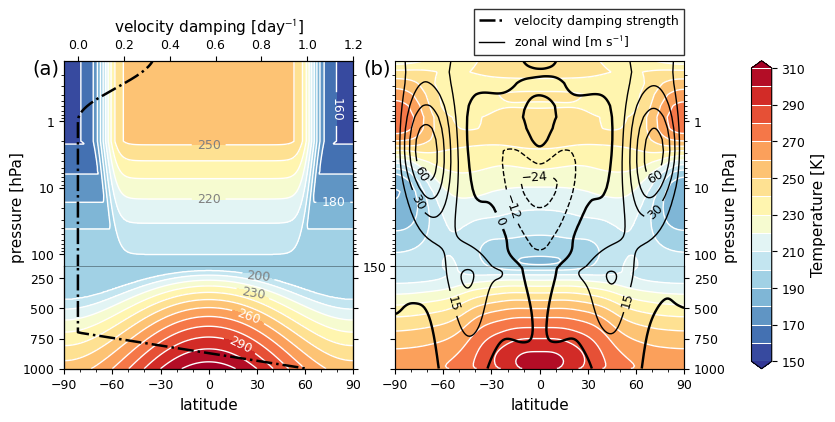

In [7]:
# =====================================
# ======= make figure =================

fig = plt.figure(figsize=(8, 4))
gs  = GridSpec(2, 2, height_ratios=[2, 1], hspace=0, wspace=0.145)

X = LAT * 180/np.pi
Y = P/100

Tlev = np.arange(150, 320, 10)
Ulev = np.arange(-30, 75, 15)
Ulev = np.hstack([np.arange(-36, 0, 12), np.arange(0, 75, 15)])

Tcmap='RdYlBu_r'
Tlw = 1
Tcolor = 'w'

Ukcolor = 'k'
Ucolor = 'k'
Ulw = 1
kvlw = 1.8
zero_line_fac = 1.75

strat_trop_pres = 150
latlim = 90
hline_alpha=0.5

lat_ticks = [-90, -60, -30, 0, 30, 60, 90]

# =====================================
# ======= Teq, damping ================

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[2])

# ------ stratosphere 
ax1.contourf(X, Y, Teq, levels=Tlev, cmap=Tcmap, extend='both')
Tcf_strat = ax1.contour(X, Y, Teq, levels=Tlev, colors=Tcolor, linewidths=Tlw)

ax1t = ax1.twiny()
ax1t.plot(krf[:,0], Y[:,0], '-.', color=Ukcolor, lw=kvlw)

# ------ troposphere 
ax2.contourf(X, Y, Teq, levels=Tlev, cmap=Tcmap, extend='both')
Tcf_trop = ax2.contour(X, Y, Teq, levels=Tlev, colors=Tcolor, linewidths=Tlw)

ax2t = ax2.twiny()
ax2t.plot(kv[:,0], Y[:,0], '-.', color=Ukcolor, lw=kvlw)

ax2t.axhline(strat_trop_pres, color='k', alpha=hline_alpha, lw=0.5, zorder=99)

# ------ formatting

ax1.set_ylim([np.min(datlev), strat_trop_pres])
ax1.invert_yaxis()
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
#ax1.set_xticks([])
ax1.set_ylabel(r'pressure [hPa]                  ', fontsize=11)
ax1.set_xlim([-latlim, latlim])
ax1.spines['bottom'].set_visible(False)

Tcf_labels_grey = [[27.5, 379], [31.2, 230], [0, 15.669], [0, 2.109]]
Tcf_labels_white = [[19.5, 801], [24.4, 578], [77.6, 16.22], [78.8, 0.659]] 
ax1.clabel(Tcf_strat, inline=True, fontsize=SMALL_SIZE, manual = [l for l in Tcf_labels_white if l[1] < strat_trop_pres], colors='white')
ax1.clabel(Tcf_strat, inline=True, fontsize=SMALL_SIZE, manual = [l for l in Tcf_labels_grey if l[1] < strat_trop_pres], colors='grey')
troplab1 = ax2.clabel(Tcf_trop, inline=True, fontsize=SMALL_SIZE, manual = [l for l in Tcf_labels_white if l[1] > strat_trop_pres], colors='white')
troplab2 = ax2.clabel(Tcf_trop, inline=True, fontsize=SMALL_SIZE, manual = [l for l in Tcf_labels_grey if l[1] > strat_trop_pres], colors='grey')

troplab = troplab1 + troplab2
troplabrot = [0, 0, -26, -20, -10, -5, 0, 0]
for i in range(len(troplab)):
    troplab[i].set_rotation(troplabrot[i])

ax1t.set_xlim([-0.06, 1.2])
ax1t.set_xlabel(r'velocity damping [day$^{-1}$]', color=Ukcolor)
ax1t.spines['bottom'].set_visible(False)

ax2.set_ylim([strat_trop_pres, 1000])
ax2.invert_yaxis()
ax2.set_xlim([-latlim, latlim])
ax2.set_xlabel(r'latitude', fontsize=11)
ax2.spines['top'].set_visible(False)
ax2.set_xticks(lat_ticks)
ax2.xaxis.set_minor_locator(MultipleLocator(10))

ax2t.set_xlim([-0.06, 1.2])
ax2t.set_xticks([])
ax2t.spines['top'].set_visible(False)

dummy = ax2.twinx()
dummy.yaxis.tick_right()
dummy.invert_yaxis()
dummy.set_ylim(ax2.get_ylim())
dummy.set_yticks([])
dummy.spines['top'].set_visible(False)
au.insert_labelled_tick(dummy, 'y', strat_trop_pres)

ax1.tick_params(left=True, right=True, labelleft=True, labelright=False, which='both')
ax2.tick_params(left=True, right=True, labelleft=True, labelright=False, which='both')


# ===========================
# ======= plot sim data =====

ax3 = fig.add_subplot(gs[1])
ax4 = fig.add_subplot(gs[3])

X, Y = np.meshgrid(datlat, datlev)

# ------ stratosphere 
ax3.contourf(X, Y, T, levels=Tlev, cmap=Tcmap, extend='both')
ax3.contour(X, Y, T, levels=Tlev, colors=Tcolor, linewidths=Tlw)

Ucf_strat = ax3.contour(X, Y, U, levels=[l for l in Ulev if l!=0], colors=Ucolor, linewidths=Ulw)
Ucf_strat_0 = ax3.contour(X, Y, U, levels=[0], colors=Ucolor, linewidths=Ulw*zero_line_fac, zorder=3)

ax4.axhline(strat_trop_pres, color='k', alpha=hline_alpha, lw=0.5, zorder=99)


# ------ troposphere 
Tcf = ax4.contourf(X, Y, T, levels=Tlev, cmap=Tcmap, extend='both')
ax4.contour(X, Y, T, levels=Tlev, colors=Tcolor, linewidths=Tlw)

Ucf_trop = ax4.contour(X, Y, U, levels=[l for l in Ulev if l!=0], colors=Ucolor, linewidths=Ulw, zorder=3)
Ucf_trop_0 = ax4.contour(X, Y, U, levels=[0], colors=Ucolor, linewidths=Ulw*zero_line_fac, zorder=3)

ax3.set_yscale('log')
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax3.set_xticks([])
ax3.set_ylim([np.min(Y), strat_trop_pres])
ax3.set_ylabel(r'pressure [hPa]                  ', fontsize=11)
ax3.yaxis.tick_right()
ax3.set_xlim([-latlim, latlim])
ax3.yaxis.set_label_position("right")
ax3.invert_yaxis()
ax3.spines['bottom'].set_visible(False)

ax4.set_ylim([strat_trop_pres, 1000])
ax4.set_xlabel(r'latitude', fontsize=11)
ax4.set_xlim([-latlim, latlim])
ax4.invert_yaxis()
ax4.spines['top'].set_visible(False)
ax4.set_xticks(lat_ticks)
ax4.xaxis.set_minor_locator(MultipleLocator(10))

Ucf_labels = [[-52.2, 454], [-77, 16.791], [-74.5, 6.1605], 
              [52.3, 420], [70.8, 21.389], [71.4, 6.602], [-15.7, 18.626], [-3.4, 8.409]]
ax3.clabel(Ucf_strat, inline=True, fontsize=SMALL_SIZE, manual=[l for l in Ucf_labels if l[1] < strat_trop_pres])
ax4.clabel(Ucf_trop, inline=True, fontsize=SMALL_SIZE, manual=[l for l in Ucf_labels if l[1] > strat_trop_pres])
ax3.clabel(Ucf_strat_0, inline=True, fontsize=SMALL_SIZE, manual=[[-26.3, 32.388]])

dummy = ax4.twinx()
dummy.yaxis.tick_left()
dummy.invert_yaxis()
dummy.set_ylim(ax4.get_ylim())
dummy.set_yticks([])
dummy.spines['top'].set_visible(False)
au.insert_labelled_tick(dummy, 'y', strat_trop_pres, label='')
ax4.yaxis.tick_right()

ax3.plot([0], [0], 'k-.', lw=kvlw, label='velocity damping strength')
ax3.plot([0], [0], 'k-', lw=Ulw, label=r'zonal wind [m s$^{-1}$]')
leg = ax3.legend(loc='upper right', bbox_to_anchor=(1.02, 1.28), 
                 fancybox=False, shadow=False, frameon=True)
leg.get_frame().set_edgecolor('k')

ax3.tick_params(left=True, right=True, labelleft=False, labelright=True, which='both')
ax4.tick_params(left=True, right=True, labelleft=False, labelright=True, which='both')

# ===============================

axins = inset_axes(ax3,
                   width="7%",
                   height="150%",
                   loc='upper left',
                   bbox_to_anchor=(1.233, 0, 1, 1),
                   bbox_transform=ax3.transAxes,
                   borderpad=0)
cbar = fig.colorbar(Tcf, cax=axins, orientation='vertical', pad=100, extendfrac=0.025)
cbar.set_label(r'Temperature [K]')
for k in range(len(Tlev)):
    axins.axhline(Tlev[k], color='w', lw=0.75)

axs = [ax1, ax3]
axlabs = ['(a)', '(b)']
for i in range(2):
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    axs[i].text(-0.015, 0.87, axlabs[i], transform=axs[i].transAxes + trans,
                fontsize=BIGGER_SIZE, va='bottom', fontfamily='sans-serif')


plt.subplots_adjust(hspace=0)
plt.tight_layout()
plt.savefig('figs/HSW_Teq.pdf', dpi=300, bbox_inches='tight')
plt.show()